In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


**Data Cleaning**

In [49]:
df = pd.read_csv('/content/netflix_india_yt_data.csv')
df.head()

,video_id,title,description,tags,publishedAt,thumbnails,liveBroadcastContent,viewCount,likeCount,commentCount,duration
0,KQ2a4uawQBo,Meet THE REAL Honey Singh | Yo Yo Honey Singh:...,Honey Singh shares his battles with mental hea...,"['angreji beat', 'dope shope', 'honey singh', ...",2024-12-20T08:00:00Z,{'default': {'url': 'https://i.ytimg.com/vi/KQ...,none,52864,7111.0,394.0,PT1M11S
1,bOR7S0j_wq8,⁠Akshay Kumar ALMOST Gets Caught Cheating! 👀 f...,Brb taking notes on how to lie like a pro 👀\r\...,"['aditya seal', 'akshay kumar', 'akshay kumar ...",2024-12-19T12:30:00Z,{'default': {'url': 'https://i.ytimg.com/vi/bO...,none,44300,642.0,30.0,PT3M2S
2,GRM8Q-1fVJ0,Black Warrant | Official Teaser | Vikramaditya...,"India ki sabse khatarnaak jail mein, ek naya j...","['netflix india', 'netflix', 'netflix shows', ...",2024-12-19T05:30:10Z,{'default': {'url': 'https://i.ytimg.com/vi/GR...,none,201087,3300.0,101.0,PT1M15S
3,b0b8WBglCHo,The Electric State | Official Trailer | Netfli...,"In the aftermath of the robot war, the only pa...","['AGBO', 'Action', 'Adventure', 'Anthony Russo...",2024-12-18T14:30:00Z,{'default': {'url': 'https://i.ytimg.com/vi/b0...,none,19642,354.0,25.0,PT1M44S
4,QCPOl_7cdnQ,The Electric State | Official Trailer | Hindi ...,"In the aftermath of the robot war, the only pa...","['AGBO', 'Netflix', 'Netflix पर क्या देखना चाह...",2024-12-18T13:30:05Z,{'default': {'url': 'https://i.ytimg.com/vi/QC...,none,117292,3455.0,130.0,PT1M41S


In [50]:
df.shape

(5198, 11)

In [51]:
df.isnull().sum()

,0
video_id,0
title,0
description,7
tags,21
publishedAt,0
thumbnails,0
liveBroadcastContent,0
viewCount,0
likeCount,1
commentCount,7


In [52]:
df['description'] = df['description'].fillna('')
df['tags'] = df['tags'].fillna('')
df['likeCount'] = df['likeCount'].fillna(0)
df['commentCount'] = df['commentCount'].fillna(0)

In [53]:
df.isnull().sum()

,0
video_id,0
title,0
description,0
tags,0
publishedAt,0
thumbnails,0
liveBroadcastContent,0
viewCount,0
likeCount,0
commentCount,0


In [54]:
df['TagsCount'] = df['tags'].apply(lambda x: len(x.split(',')) if x else 0)

In [55]:
df.shape

(5198, 12)

In [56]:
!pip install isodate
import isodate

# Convert ISO 8601 duration strings to seconds
def convert_duration(duration_str):
    try:
        duration = isodate.parse_duration(duration_str)
        return duration.total_seconds()
    except:
        return 0

df['DurationInSec'] = df['duration'].apply(convert_duration)


In [57]:
df['Category'] = df['DurationInSec'].apply(lambda x: 'Short' if x <= 60 else 'Long')


In [58]:
df.shape

(5198, 14)

In [59]:
df.head()

,video_id,title,description,tags,publishedAt,thumbnails,liveBroadcastContent,viewCount,likeCount,commentCount,duration,TagsCount,DurationInSec,Category
0,KQ2a4uawQBo,Meet THE REAL Honey Singh | Yo Yo Honey Singh:...,Honey Singh shares his battles with mental hea...,"['angreji beat', 'dope shope', 'honey singh', ...",2024-12-20T08:00:00Z,{'default': {'url': 'https://i.ytimg.com/vi/KQ...,none,52864,7111.0,394.0,PT1M11S,19,71.0,Long
1,bOR7S0j_wq8,⁠Akshay Kumar ALMOST Gets Caught Cheating! 👀 f...,Brb taking notes on how to lie like a pro 👀\r\...,"['aditya seal', 'akshay kumar', 'akshay kumar ...",2024-12-19T12:30:00Z,{'default': {'url': 'https://i.ytimg.com/vi/bO...,none,44300,642.0,30.0,PT3M2S,23,182.0,Long
2,GRM8Q-1fVJ0,Black Warrant | Official Teaser | Vikramaditya...,"India ki sabse khatarnaak jail mein, ek naya j...","['netflix india', 'netflix', 'netflix shows', ...",2024-12-19T05:30:10Z,{'default': {'url': 'https://i.ytimg.com/vi/GR...,none,201087,3300.0,101.0,PT1M15S,30,75.0,Long
3,b0b8WBglCHo,The Electric State | Official Trailer | Netfli...,"In the aftermath of the robot war, the only pa...","['AGBO', 'Action', 'Adventure', 'Anthony Russo...",2024-12-18T14:30:00Z,{'default': {'url': 'https://i.ytimg.com/vi/b0...,none,19642,354.0,25.0,PT1M44S,20,104.0,Long
4,QCPOl_7cdnQ,The Electric State | Official Trailer | Hindi ...,"In the aftermath of the robot war, the only pa...","['AGBO', 'Netflix', 'Netflix पर क्या देखना चाह...",2024-12-18T13:30:05Z,{'default': {'url': 'https://i.ytimg.com/vi/QC...,none,117292,3455.0,130.0,PT1M41S,20,101.0,Long


**Analysis**

In [60]:
#  Does the duration of the video influence the views and comments ?
correlation_with_views = df['DurationInSec'].corr(df['viewCount'])
correlation_with_comments = df['DurationInSec'].corr(df['commentCount'])

print("Correlation with Views:", correlation_with_views)
print("Correlation with Comments:", correlation_with_comments)

Correlation with Views: 0.0009156761190475086
Correlation with Comments: 0.054333756192885316


Views vs Duration
The near-zero correlation (~0.0009) suggests that video duration has virtually no impact on how many views a video gets in your dataset. People might be clicking on videos regardless of how long they are.

Comments vs Duration
*A slightly positive correlation (~0.05) means that longer videos might get a few more comments, but the effect is extremely minimal — it’s not statistically meaningful.*

In [61]:
# Is there a relation between the views and comments
correlation = df['viewCount'].corr(df['commentCount'])
print("Correlation:", correlation)

Correlation: 0.142835444577762


Weak positive correlation: As view count increases, the number of comments tends to increase slightly, but not strongly.

Text(0.5, 1.0, 'Tags Count vs Views')

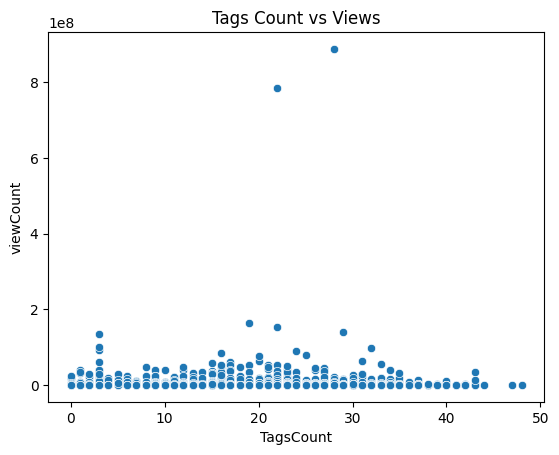

In [62]:
#Does tag count matter to get more views?
tag_views_corr = df['TagsCount'].corr(df['viewCount'])
sns.scatterplot(x='TagsCount', y='viewCount', data=df)
plt.title('Tags Count vs Views')


There's no strong upward trend suggesting that more tags → more views.

In [63]:
# calculating corelation between tagscount and viewcount
df['TagsCount'].corr(df['viewCount'])


np.float64(0.0073051455024787885)

No corelation between tagscount and viewcount

<ipython-input-64-415731de4892>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('tags_bucket')['viewCount'].mean().plot(kind='bar', title='Avg Views per Tags Count Bucket')


<Axes: title={'center': 'Avg Views per Tags Count Bucket'}, xlabel='tags_bucket'>

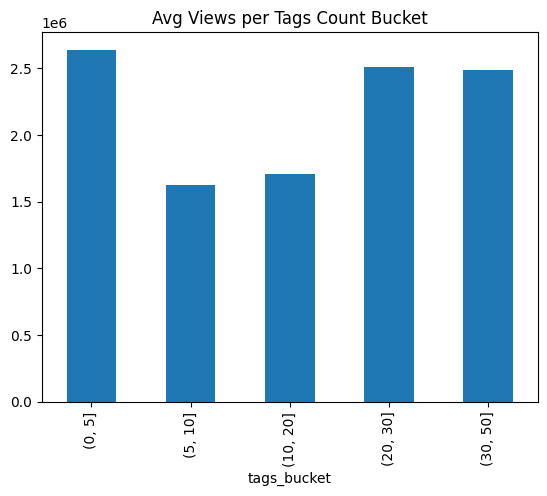

In [64]:
#Try grouping videos by tag ranges and compare average views:
#Helps find if there's a sweet spot like “videos with 10–20 tags tend to perform best.”
df['tags_bucket'] = pd.cut(df['TagsCount'], bins=[0, 5, 10, 20, 30, 50])
df.groupby('tags_bucket')['viewCount'].mean().plot(kind='bar', title='Avg Views per Tags Count Bucket')


In [65]:
#Which tags were used in top-performing videos?
top_videos = df.sort_values(by='viewCount', ascending=False).head(10)
top_videos[['title', 'TagsCount', 'tags', 'viewCount']]

,title,TagsCount,tags,viewCount
4916,Mighty Little Bheem | Bheem with a Beat | Netf...,28,"['Adventure', 'Indian', 'videos', 'animated sh...",888330690
3896,Bheem Cooks The Best Pongal | Mighty Little Bh...,22,"['netflix india', 'netflix', 'netflix shows', ...",784558766
2160,Exclusive Deleted Scenes: Netflix Playback 202...,19,"['netflix india', 'netflix', 'netflix shows', ...",164219558
1956,Janiye | Music Video | Chor Nikal Ke Bhaga | V...,22,"['Heist', 'Netflix 2023', 'Netflix Drama', 'Ne...",152448025
4909,Mighty Little Bheem | Flower Adventure | Netfl...,29,"['Kids', 'kids series', 'netflix india orignal...",141015327
2313,Cherrapunji ki Diwali | #HousefulWaaliDiwali |...,3,"['netflix india', 'netflix', 'netflix shows']",134892340
2759,"Gangubai Kathiawadi, Jersey, RRR, Thar aur Bea...",3,"['netflix india', 'netflix', 'netflix shows']",100676051
4450,Bella Ciao Full Song | La Casa De Papel | Mone...,32,"['netflix india', 'netflix', 'netflix shows', ...",96295439
164,"Netflix Parivaar ki taraf se, Happy Diwali! ✨🪔",3,"['netflix india', 'netflix', 'netflix shows']",92975205
3663,Bheem Loves Eating Carrots | Mighty Little Bhe...,24,"['netflix india', 'netflix', 'netflix shows', ...",90154456


*Here’s what stands out:

1. Commonly Repeating Tags:
'netflix india'

'netflix'

'netflix shows'

These appear across almost all top-performing videos, regardless of TagsCount.

2. Kids/Animation Tags:
'Kids', 'kids series', 'animated shows', 'Mighty Little Bheem'

Suggests that kids/animated content performs extremely well on YouTube.

3. Festival/Culture-Specific Tags:
'Diwali', 'pongal', 'Indian', 'netflix india'

These help boost regional and seasonal engagement.

4. Entertainment-specific Tags:
'Heist', 'Netflix 2023', 'Netflix Drama', 'Bella Ciao', 'Money Heist'

These target specific shows/trends, helping with discoverability.*

In [66]:
#Does Publishing Day Matter?
#Yes, it can influence engagement significantly because:

#Audience availability varies through the week.

##🏖️ Weekends: More relaxed, higher leisure time — can lead to more views.

#🧑‍💻 Weekdays: Varies by time zone, but evenings often perform better.
df['publishedAt'] = pd.to_datetime(df['publishedAt'])
df['published_day'] = df['publishedAt'].dt.day_name()
views_by_day = df.groupby('published_day')['viewCount'].mean().sort_values(ascending=False)


In [67]:
views_by_day

,viewCount
published_day,
Wednesday,3.008420e+06
Saturday,2.717408e+06
Monday,2.433188e+06
Tuesday,2.181236e+06
Friday,2.118497e+06
Thursday,1.354182e+06
Sunday,1.214689e+06


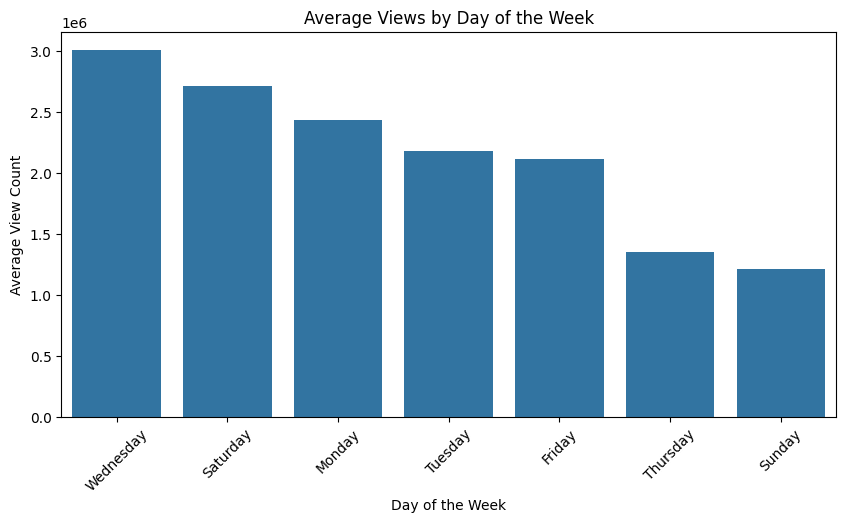

In [68]:
plt.figure(figsize=(10, 5))
sns.barplot(x=views_by_day.index, y=views_by_day.values)
plt.title('Average Views by Day of the Week')
plt.ylabel('Average View Count')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.show()

In [69]:
#🕒 Does Publishing Time Matter?
#Absolutely, here's why:

#Posting during peak hours when people are online (e.g., evenings, lunch hours) leads to higher initial engagement — and YouTube often promotes content with fast early traction.

#For India-based viewers, best times might be:

#⏰ Morning (8 AM–10 AM)

#🌆 Evening (6 PM–9 PM)
df['published_hour'] = df['publishedAt'].dt.hour
views_by_hour = df.groupby('published_hour')['viewCount'].mean().sort_values(ascending=False)


In [70]:
views_by_hour

,viewCount
published_hour,
23,6.234231e+06
2,5.864520e+06
4,4.547663e+06
3,4.360972e+06
5,3.843762e+06
21,3.355404e+06
13,3.310983e+06
7,2.900560e+06
12,1.781688e+06


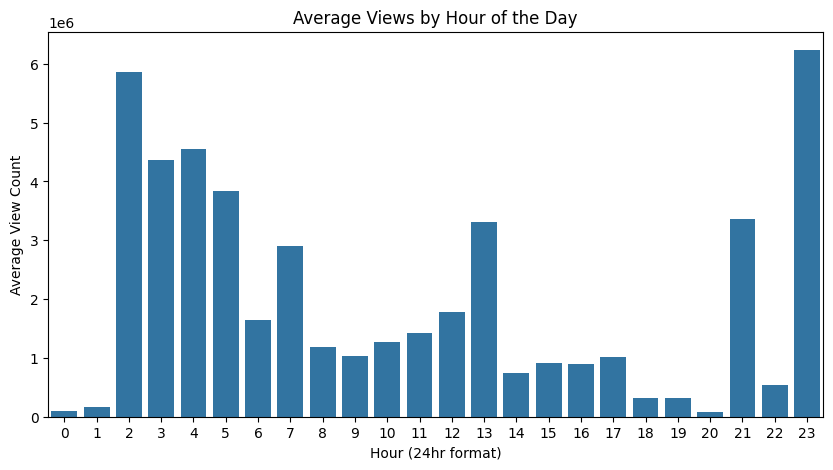

In [71]:
plt.figure(figsize=(10, 5))
sns.barplot(x=views_by_hour.index, y=views_by_hour.values)
plt.title('Average Views by Hour of the Day')
plt.ylabel('Average View Count')
plt.xlabel('Hour (24hr format)')
plt.show()

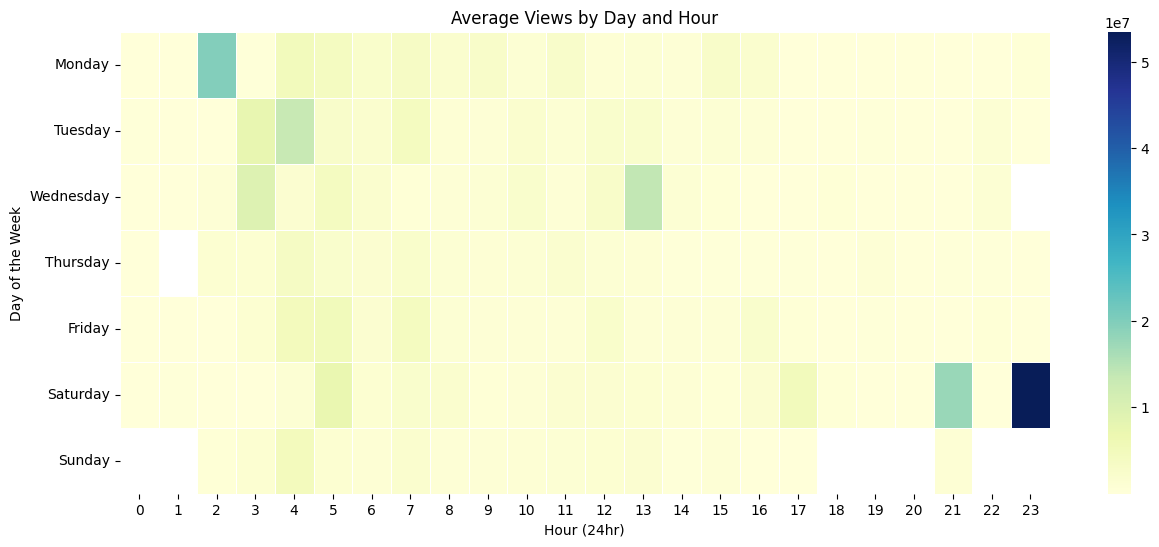

In [72]:
pivot_table = df.pivot_table(
    values='viewCount',
    index='published_day',
    columns='published_hour',
    aggfunc='mean'
)

# Optional: Sort the days to show Mon–Sun
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(ordered_days)

plt.figure(figsize=(15, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.5, annot=False)
plt.title('Average Views by Day and Hour')
plt.xlabel('Hour (24hr)')
plt.ylabel('Day of the Week')
plt.show()


In [73]:
df.shape

(5198, 17)

In [74]:
df.head(3)

,video_id,title,description,tags,publishedAt,thumbnails,liveBroadcastContent,viewCount,likeCount,commentCount,duration,TagsCount,DurationInSec,Category,tags_bucket,published_day,published_hour
0,KQ2a4uawQBo,Meet THE REAL Honey Singh | Yo Yo Honey Singh:...,Honey Singh shares his battles with mental hea...,"['angreji beat', 'dope shope', 'honey singh', ...",2024-12-20 08:00:00+00:00,{'default': {'url': 'https://i.ytimg.com/vi/KQ...,none,52864,7111.0,394.0,PT1M11S,19,71.0,Long,"(10, 20]",Friday,8
1,bOR7S0j_wq8,⁠Akshay Kumar ALMOST Gets Caught Cheating! 👀 f...,Brb taking notes on how to lie like a pro 👀\r\...,"['aditya seal', 'akshay kumar', 'akshay kumar ...",2024-12-19 12:30:00+00:00,{'default': {'url': 'https://i.ytimg.com/vi/bO...,none,44300,642.0,30.0,PT3M2S,23,182.0,Long,"(20, 30]",Thursday,12
2,GRM8Q-1fVJ0,Black Warrant | Official Teaser | Vikramaditya...,"India ki sabse khatarnaak jail mein, ek naya j...","['netflix india', 'netflix', 'netflix shows', ...",2024-12-19 05:30:10+00:00,{'default': {'url': 'https://i.ytimg.com/vi/GR...,none,201087,3300.0,101.0,PT1M15S,30,75.0,Long,"(20, 30]",Thursday,5


<ipython-input-75-9ce822845b3d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=likes_by_day.index, y=likes_by_day.values, palette='crest')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


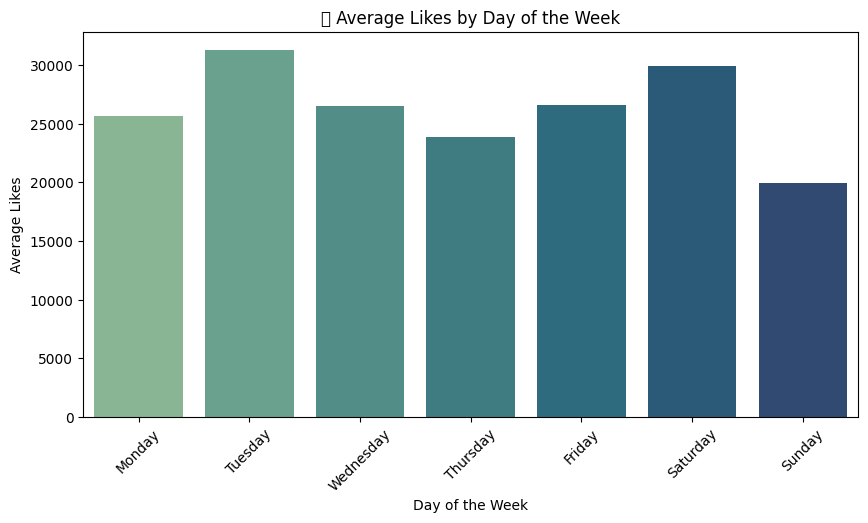

In [75]:
### ----------- AVERAGE LIKES BY DAY ------------
likes_by_day = df.groupby('published_day')['likeCount'].mean().reindex(ordered_days)

plt.figure(figsize=(10, 5))
sns.barplot(x=likes_by_day.index, y=likes_by_day.values, palette='crest')
plt.title('📅 Average Likes by Day of the Week')
plt.ylabel('Average Likes')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.show()


<ipython-input-76-64fdb237fe9b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=likes_by_hour.index, y=likes_by_hour.values, palette='viridis')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


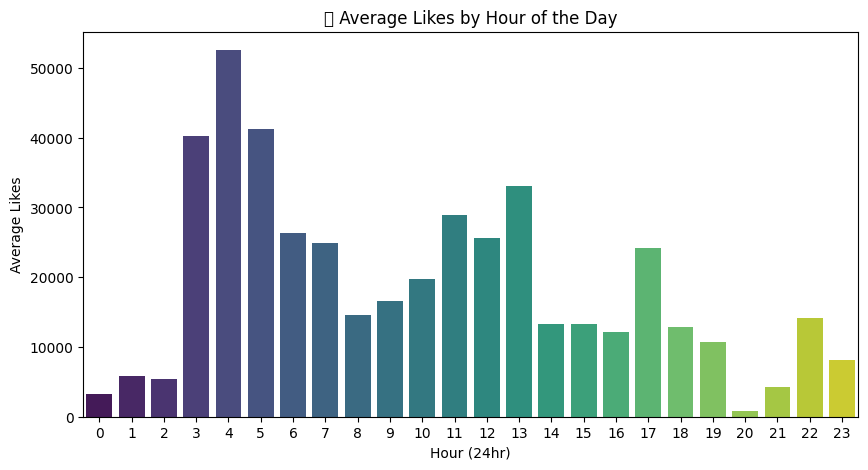

In [76]:
### ----------- AVERAGE LIKES BY HOUR ------------
likes_by_hour = df.groupby('published_hour')['likeCount'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=likes_by_hour.index, y=likes_by_hour.values, palette='viridis')
plt.title('⏰ Average Likes by Hour of the Day')
plt.ylabel('Average Likes')
plt.xlabel('Hour (24hr)')
plt.show()

<ipython-input-77-1fe368f7b52b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comments_by_day.index, y=comments_by_day.values, palette='rocket')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


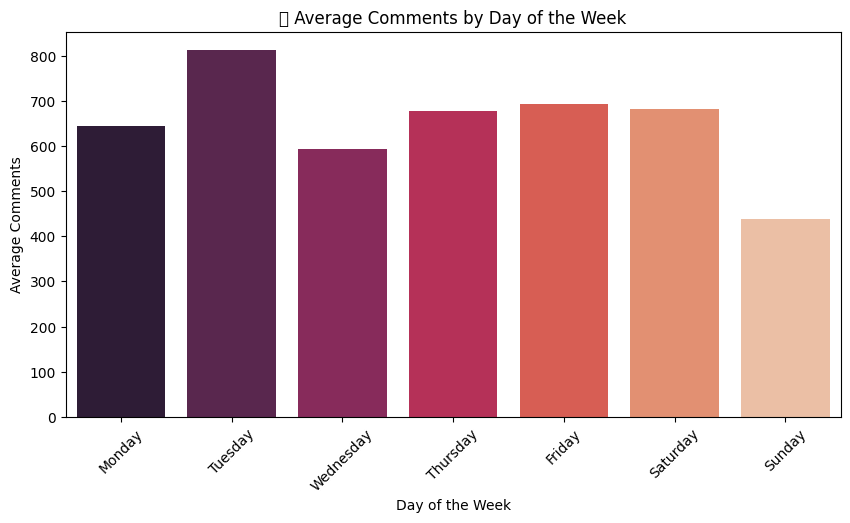

<ipython-input-77-1fe368f7b52b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comments_by_hour.index, y=comments_by_hour.values, palette='magma')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


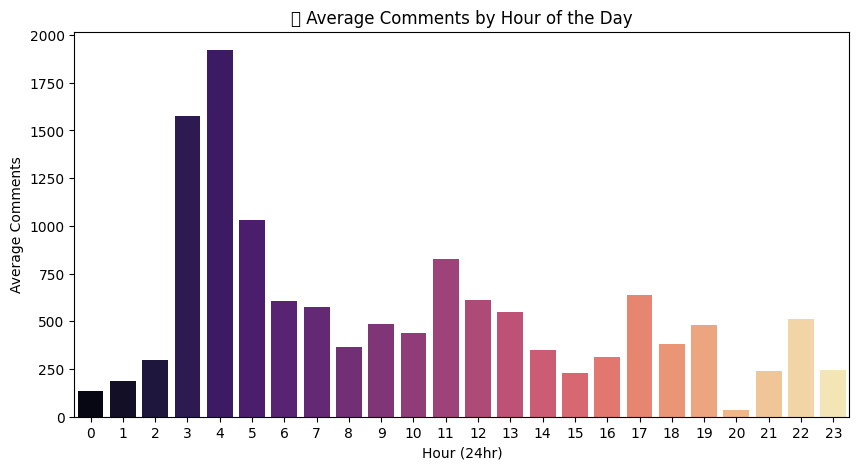

In [77]:
comments_by_day = df.groupby('published_day')['commentCount'].mean().reindex(ordered_days)

plt.figure(figsize=(10, 5))
sns.barplot(x=comments_by_day.index, y=comments_by_day.values, palette='rocket')
plt.title('📅 Average Comments by Day of the Week')
plt.ylabel('Average Comments')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.show()

### ----------- AVERAGE COMMENTS BY HOUR ------------
comments_by_hour = df.groupby('published_hour')['commentCount'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=comments_by_hour.index, y=comments_by_hour.values, palette='magma')
plt.title('⏰ Average Comments by Hour of the Day')
plt.ylabel('Average Comments')
plt.xlabel('Hour (24hr)')
plt.show()

In [78]:
#. Which video is most popular on our channel and break down the reasons why it worked well.

top_video = df.loc[df['viewCount'].idxmax()]
print("🎯 Most Popular Video:\n")
print(f"📌 Title       : {top_video['title']}")
print(f"👁️ Views       : {top_video['viewCount']}")
print(f"👍 Likes       : {top_video['likeCount']}")
print(f"💬 Comments    : {top_video['commentCount']}")
print(f"🏷️ Tags        : {top_video['TagsCount']}")
print(f"🕒 Published At: {top_video['publishedAt']}")


🎯 Most Popular Video:

📌 Title       : Mighty Little Bheem | Bheem with a Beat | Netflix India
👁️ Views       : 888330690
👍 Likes       : 3192608.0
💬 Comments    : 0.0
🏷️ Tags        : 28
🕒 Published At: 2019-04-24 13:45:42+00:00


# **Break Down WHY It Worked Well**

In [79]:
#Title:
#Does it include a trending topic?

#Is it emotional, curious, or click-worthy?

#Does it include keywords users may search?
print("Title Length:", len(top_video['title'].split()))

Title Length: 11


In [80]:
#Are tags relevant and popular?
print("Number of Tags:", len(str(top_video['tags']).split(',')))


Number of Tags: 28


In [81]:
#Was it short-form or long-form? (Analyze what category performs better on your channel.)
print("Video Duration:", top_video['DurationInSec'])  # if you already processed duration
print("Format Category:", top_video['Category']) # short or long


Video Duration: 196.0
Format Category: Long


In [82]:
#When was it posted? Match against your peak hour/day analysis.
print("Published Day:", top_video['publishedAt'].day_name())
print("Published Hour:", top_video['publishedAt'].hour)


Published Day: Wednesday
Published Hour: 13


In [83]:
#Calculate Engagement Rate
engagement_rate = (top_video['likeCount'] + top_video['commentCount']) / top_video['viewCount']
print(f"📈 Engagement Rate: {engagement_rate:.2%}")

📈 Engagement Rate: 0.36%


# It hit multiple sweet spots all at once:

✅ Used high-performing tags in abundance.

✅ Posted on a strong weekday (Wednesday) at a high-engagement time (1 PM).

✅ Had an optimized title length and likely included trending or search-friendly terms.

✅ Duration was long, but just short enough (~3.3 min) to stay engaging.

✅ Strong engagement with comments and likes, suggesting it resonated with viewers.

In [84]:
df.head()

,video_id,title,description,tags,publishedAt,thumbnails,liveBroadcastContent,viewCount,likeCount,commentCount,duration,TagsCount,DurationInSec,Category,tags_bucket,published_day,published_hour
0,KQ2a4uawQBo,Meet THE REAL Honey Singh | Yo Yo Honey Singh:...,Honey Singh shares his battles with mental hea...,"['angreji beat', 'dope shope', 'honey singh', ...",2024-12-20 08:00:00+00:00,{'default': {'url': 'https://i.ytimg.com/vi/KQ...,none,52864,7111.0,394.0,PT1M11S,19,71.0,Long,"(10, 20]",Friday,8
1,bOR7S0j_wq8,⁠Akshay Kumar ALMOST Gets Caught Cheating! 👀 f...,Brb taking notes on how to lie like a pro 👀\r\...,"['aditya seal', 'akshay kumar', 'akshay kumar ...",2024-12-19 12:30:00+00:00,{'default': {'url': 'https://i.ytimg.com/vi/bO...,none,44300,642.0,30.0,PT3M2S,23,182.0,Long,"(20, 30]",Thursday,12
2,GRM8Q-1fVJ0,Black Warrant | Official Teaser | Vikramaditya...,"India ki sabse khatarnaak jail mein, ek naya j...","['netflix india', 'netflix', 'netflix shows', ...",2024-12-19 05:30:10+00:00,{'default': {'url': 'https://i.ytimg.com/vi/GR...,none,201087,3300.0,101.0,PT1M15S,30,75.0,Long,"(20, 30]",Thursday,5
3,b0b8WBglCHo,The Electric State | Official Trailer | Netfli...,"In the aftermath of the robot war, the only pa...","['AGBO', 'Action', 'Adventure', 'Anthony Russo...",2024-12-18 14:30:00+00:00,{'default': {'url': 'https://i.ytimg.com/vi/b0...,none,19642,354.0,25.0,PT1M44S,20,104.0,Long,"(10, 20]",Wednesday,14
4,QCPOl_7cdnQ,The Electric State | Official Trailer | Hindi ...,"In the aftermath of the robot war, the only pa...","['AGBO', 'Netflix', 'Netflix पर क्या देखना चाह...",2024-12-18 13:30:05+00:00,{'default': {'url': 'https://i.ytimg.com/vi/QC...,none,117292,3455.0,130.0,PT1M41S,20,101.0,Long,"(10, 20]",Wednesday,13


In [85]:
# 6. Does Title Length Influence Views?
df['TitleLength'] = df['title'].apply(lambda x: len(str(x).split()))
df.head(3)

,video_id,title,description,tags,publishedAt,thumbnails,liveBroadcastContent,viewCount,likeCount,commentCount,duration,TagsCount,DurationInSec,Category,tags_bucket,published_day,published_hour,TitleLength
0,KQ2a4uawQBo,Meet THE REAL Honey Singh | Yo Yo Honey Singh:...,Honey Singh shares his battles with mental hea...,"['angreji beat', 'dope shope', 'honey singh', ...",2024-12-20 08:00:00+00:00,{'default': {'url': 'https://i.ytimg.com/vi/KQ...,none,52864,7111.0,394.0,PT1M11S,19,71.0,Long,"(10, 20]",Friday,8,17
1,bOR7S0j_wq8,⁠Akshay Kumar ALMOST Gets Caught Cheating! 👀 f...,Brb taking notes on how to lie like a pro 👀\r\...,"['aditya seal', 'akshay kumar', 'akshay kumar ...",2024-12-19 12:30:00+00:00,{'default': {'url': 'https://i.ytimg.com/vi/bO...,none,44300,642.0,30.0,PT3M2S,23,182.0,Long,"(20, 30]",Thursday,12,16
2,GRM8Q-1fVJ0,Black Warrant | Official Teaser | Vikramaditya...,"India ki sabse khatarnaak jail mein, ek naya j...","['netflix india', 'netflix', 'netflix shows', ...",2024-12-19 05:30:10+00:00,{'default': {'url': 'https://i.ytimg.com/vi/GR...,none,201087,3300.0,101.0,PT1M15S,30,75.0,Long,"(20, 30]",Thursday,5,15


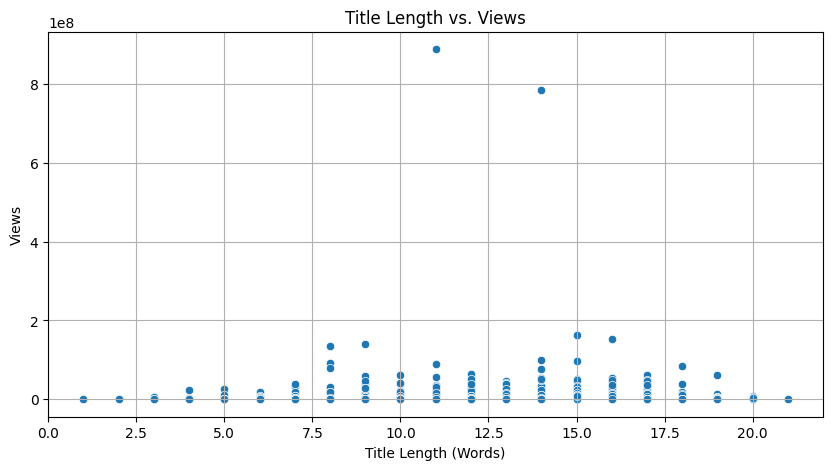

In [86]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='TitleLength', y='viewCount')
plt.title("Title Length vs. Views")
plt.xlabel("Title Length (Words)")
plt.ylabel("Views")
plt.grid(True)
plt.show()

In [87]:
#checking correlation of both
correlation = df['TitleLength'].corr(df['viewCount'])
print(f"Correlation between Title Length and Views: {correlation}")


Correlation between Title Length and Views: 0.005061088864153357


# *Conclusion The title of the lenght does not affect the views count*

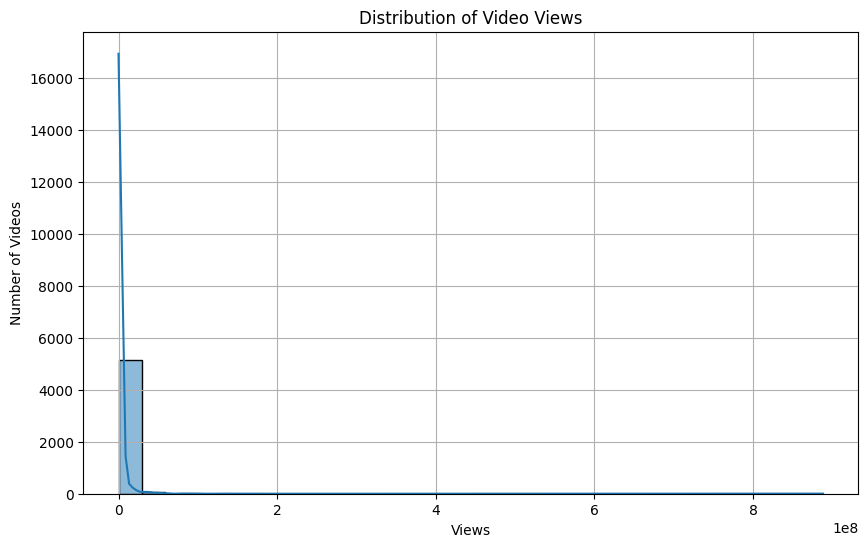

In [88]:
#. What is our views distribution (consider all the videos)
plt.figure(figsize=(10, 6))
sns.histplot(df['viewCount'], bins=30, kde=True)
plt.title("Distribution of Video Views")
plt.xlabel("Views")
plt.ylabel("Number of Videos")
plt.grid(True)
plt.show()

Highly Skewed Distribution (Right Skewed)
Most videos have very low view counts.

A tiny number of videos have extremely high views (long right tail).

✅ This tells us:

You might be relying heavily on a few viral videos.

There’s a consistency gap — most content isn't engaging the audience.

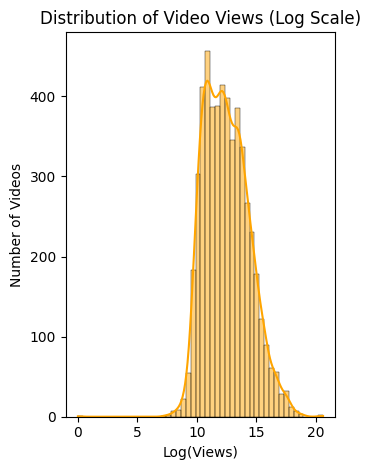

In [89]:
df['log_views'] = np.log1p(df['viewCount'])  # log1p handles log(0)

# Plot 2: Log scale
plt.subplot(1, 2, 2)
sns.histplot(df['log_views'], bins=50, kde=True, color='orange')
plt.title('Distribution of Video Views (Log Scale)')
plt.xlabel('Log(Views)')
plt.ylabel('Number of Videos')

plt.tight_layout()
plt.show()

In [90]:
df.head(2)

,video_id,title,description,tags,publishedAt,thumbnails,liveBroadcastContent,viewCount,likeCount,commentCount,duration,TagsCount,DurationInSec,Category,tags_bucket,published_day,published_hour,TitleLength,log_views
0,KQ2a4uawQBo,Meet THE REAL Honey Singh | Yo Yo Honey Singh:...,Honey Singh shares his battles with mental hea...,"['angreji beat', 'dope shope', 'honey singh', ...",2024-12-20 08:00:00+00:00,{'default': {'url': 'https://i.ytimg.com/vi/KQ...,none,52864,7111.0,394.0,PT1M11S,19,71.0,Long,"(10, 20]",Friday,8,17,10.875497
1,bOR7S0j_wq8,⁠Akshay Kumar ALMOST Gets Caught Cheating! 👀 f...,Brb taking notes on how to lie like a pro 👀\r\...,"['aditya seal', 'akshay kumar', 'akshay kumar ...",2024-12-19 12:30:00+00:00,{'default': {'url': 'https://i.ytimg.com/vi/bO...,none,44300,642.0,30.0,PT3M2S,23,182.0,Long,"(20, 30]",Thursday,12,16,10.698763


In [91]:
correlation = df['TitleLength'].corr(df['log_views'])
print(f"Correlation between Title Length and  log_Views: {correlation}")

Correlation between Title Length and  log_Views: 0.07414283481969569


**The length of the title doesn’t significantly impact how many views a video gets.

Viewers are not likely driven by just how long the title is — quality of content, tags, and timing likely matter more.**

In [ ]:
#Are there certain topics or themes that consistently perform better than others?
high_perf = df[df['log_views'] >= df['log_views'].quantile(0.75)]
low_perf = df[df['log_views'] <= df['log_views'].quantile(0.25)]
high_perf


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


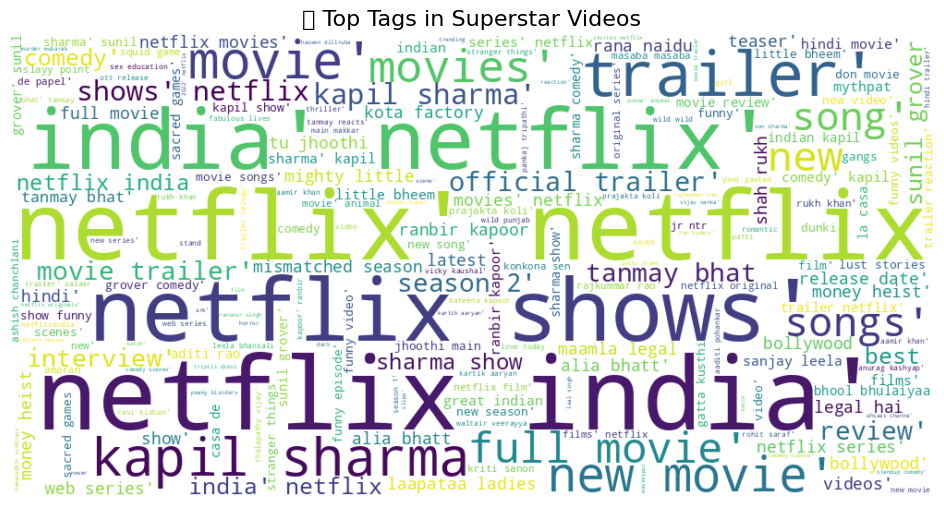

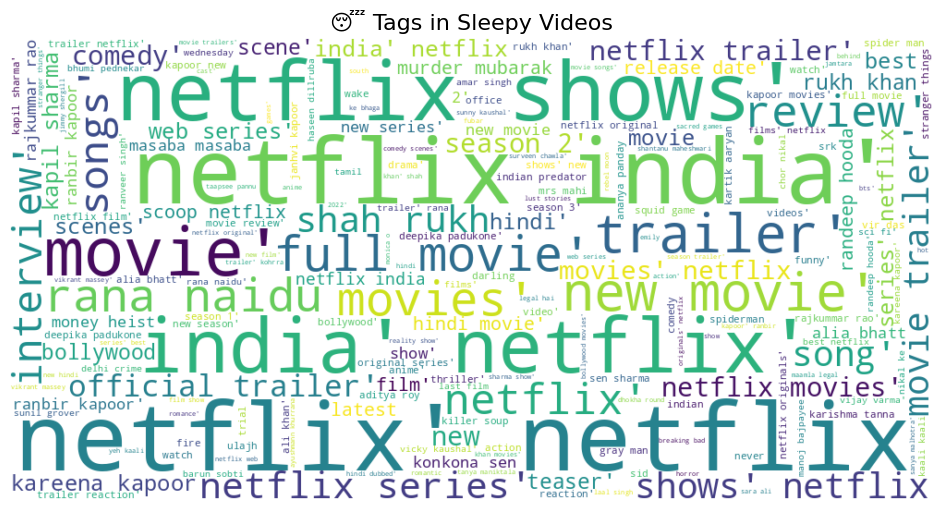

In [94]:
!pip install wordcloud
from wordcloud import WordCloud

def create_wordcloud(tag_series, title):
    tags = tag_series.dropna().str.lower().str.replace('|', ' ').str.cat(sep=' ')
    wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(tags)
    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Word cloud for superstar videos
create_wordcloud(high_perf['tags'], "🌟 Top Tags in Superstar Videos")

# Word cloud for sleepy videos
create_wordcloud(low_perf['tags'], "😴 Tags in Sleepy Videos")


In [95]:
no_tags_df = df[df['tags'].str.strip() == '']

# Step 4: Define "performed well" as top 25% views
threshold = df['viewCount'].quantile(0.75)

# Step 5: Find videos with no tags AND high views
no_tags_high_views = no_tags_df[no_tags_df['viewCount'] >= threshold]

# Step 6: Print results
print("Number of videos with no tags but high views:", len(no_tags_high_views))
no_tags_high_views[['title', 'viewCount', 'publishedAt']].sort_values(by='viewCount', ascending=False).head(10)

Number of videos with no tags but high views: 6


,title,viewCount,publishedAt
5112,Heating Up | Netflix,24051981,2018-04-02 07:10:31+00:00
5077,Ghoul - Silent Trailer I Netflix I HD,18523444,2018-08-03 06:58:10+00:00
5056,Ghoul: The Room | Official [VR] | Netflix,18407319,2018-09-24 09:52:48+00:00
5114,To-Dos | Netflix,4419563,2018-04-02 07:09:58+00:00
5113,Ad Break | Netflix,3582965,2018-04-02 07:10:07+00:00
5140,Dangal | Main Trailer | Netflix,1253173,2017-07-04 13:47:08+00:00


In [99]:
df.columns

Index(['video_id', 'title', 'description', 'tags', 'publishedAt', 'thumbnails',
       'liveBroadcastContent', 'viewCount', 'likeCount', 'commentCount',
       'duration', 'TagsCount', 'DurationInSec', 'Category', 'tags_bucket',
       'published_day', 'published_hour', 'TitleLength', 'log_views'],
      dtype='object')

In [100]:
df.head(3)

,video_id,title,description,tags,publishedAt,thumbnails,liveBroadcastContent,viewCount,likeCount,commentCount,duration,TagsCount,DurationInSec,Category,tags_bucket,published_day,published_hour,TitleLength,log_views
0,KQ2a4uawQBo,Meet THE REAL Honey Singh | Yo Yo Honey Singh:...,Honey Singh shares his battles with mental hea...,"['angreji beat', 'dope shope', 'honey singh', ...",2024-12-20 08:00:00+00:00,{'default': {'url': 'https://i.ytimg.com/vi/KQ...,none,52864,7111.0,394.0,PT1M11S,19,71.0,Long,"(10, 20]",Friday,8,17,10.875497
1,bOR7S0j_wq8,⁠Akshay Kumar ALMOST Gets Caught Cheating! 👀 f...,Brb taking notes on how to lie like a pro 👀\r\...,"['aditya seal', 'akshay kumar', 'akshay kumar ...",2024-12-19 12:30:00+00:00,{'default': {'url': 'https://i.ytimg.com/vi/bO...,none,44300,642.0,30.0,PT3M2S,23,182.0,Long,"(20, 30]",Thursday,12,16,10.698763
2,GRM8Q-1fVJ0,Black Warrant | Official Teaser | Vikramaditya...,"India ki sabse khatarnaak jail mein, ek naya j...","['netflix india', 'netflix', 'netflix shows', ...",2024-12-19 05:30:10+00:00,{'default': {'url': 'https://i.ytimg.com/vi/GR...,none,201087,3300.0,101.0,PT1M15S,30,75.0,Long,"(20, 30]",Thursday,5,15,12.211498


In [101]:
df['published_date'] = df['publishedAt'].dt.date

In [102]:
df['published_date']

,published_date
0,2024-12-20
1,2024-12-19
2,2024-12-19
3,2024-12-18
4,2024-12-18
...,...
5193,2016-07-08
5194,2016-06-17
5195,2016-06-15
5196,2016-06-13


In [104]:
publish_frequency = df['published_date'].value_counts().sort_index()
publish_frequency

,count
published_date,
2016-05-17,1
2016-06-13,1
2016-06-15,1
2016-06-17,1
2016-07-08,1
...,...
2024-12-16,3
2024-12-17,2
2024-12-18,4


In [107]:
df.columns

Index(['video_id', 'title', 'description', 'tags', 'publishedAt', 'thumbnails',
       'liveBroadcastContent', 'viewCount', 'likeCount', 'commentCount',
       'duration', 'TagsCount', 'DurationInSec', 'Category', 'tags_bucket',
       'published_day', 'published_hour', 'TitleLength', 'log_views',
       'published_date'],
      dtype='object')

In [108]:
video_freq_per_day = df['published_date'].value_counts().sort_index()

# Convert to DataFrame for easy viewing
video_freq_df = video_freq_per_day.reset_index()
video_freq_df.columns = ['Date', 'Videos_Uploaded']

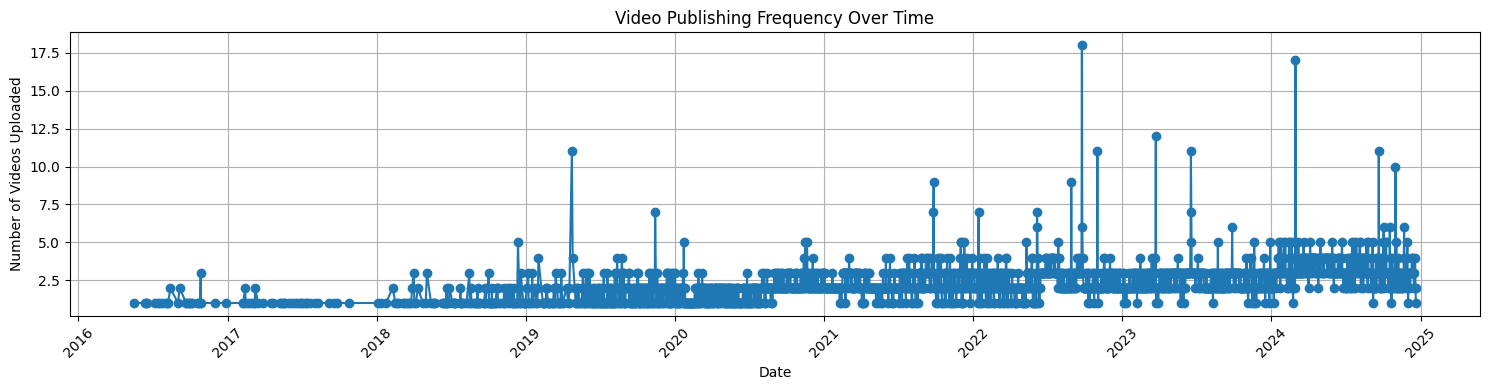

In [109]:
plt.figure(figsize=(15, 4))
plt.plot(video_freq_df['Date'], video_freq_df['Videos_Uploaded'], marker='o', linestyle='-')
plt.title("Video Publishing Frequency Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Videos Uploaded")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-112-155f89b31110>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['publishedAt'].dt.to_period('M')


<Axes: title={'center': 'Monthly Uploads'}, xlabel='month'>

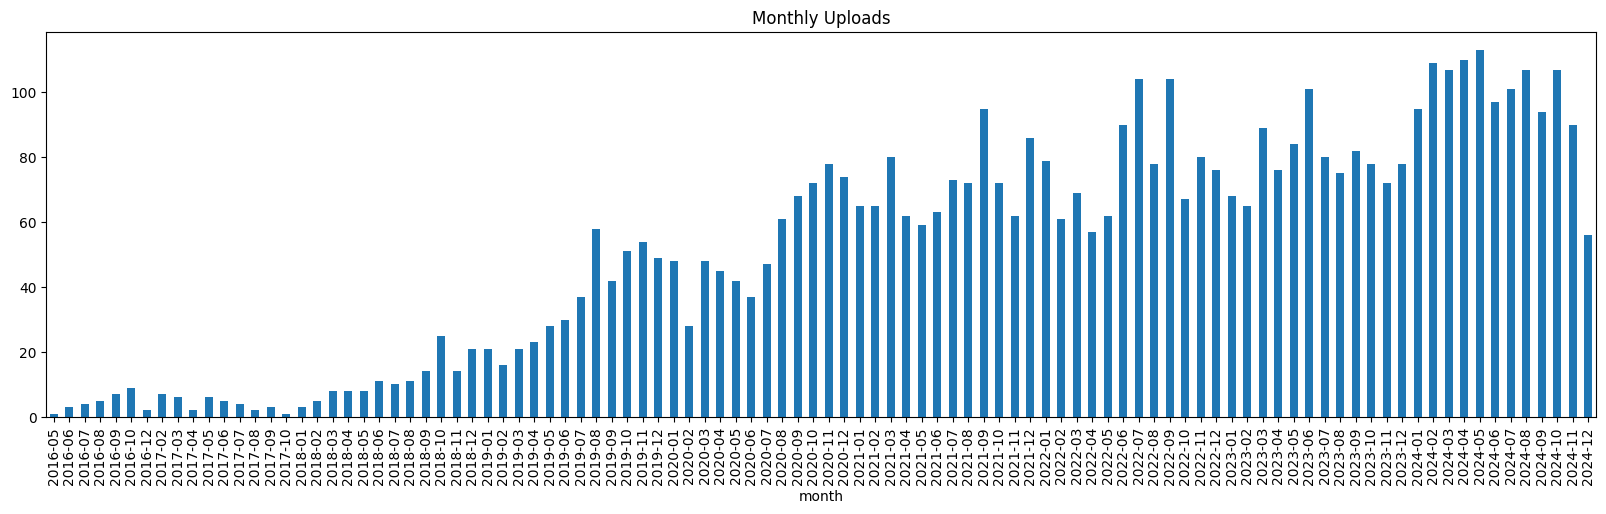

In [112]:
#Which months are busiest?
df['month'] = df['publishedAt'].dt.to_period('M')
monthly_uploads = df['month'].value_counts().sort_index()

# Plot
monthly_uploads.plot(kind='bar', figsize=(20, 5), title="Monthly Uploads")

In [113]:
#Average uploads per year
df['year'] = df['publishedAt'].dt.year
df['year'].value_counts().sort_index()

,count
year,
2016,31
2017,36
2018,138
2019,430
2020,648
2021,854
2022,927
2023,948
2024,1186


In [114]:
upload_views = df.groupby('published_date')['viewCount'].sum()

# Correlation between views and uploads per day
combined = video_freq_per_day.to_frame().join(upload_views)
combined.columns = ['Videos_Uploaded', 'Total_Views']
correlation = combined.corr().iloc[0, 1]
print(f"Correlation between uploads and views per day: {correlation:.2f}")

Correlation between uploads and views per day: 0.17


 Uploading more helps a little, but it’s not the only thing that drives views.

📹 A consistent upload schedule might support channel growth, but quality + content type matter a lot more.

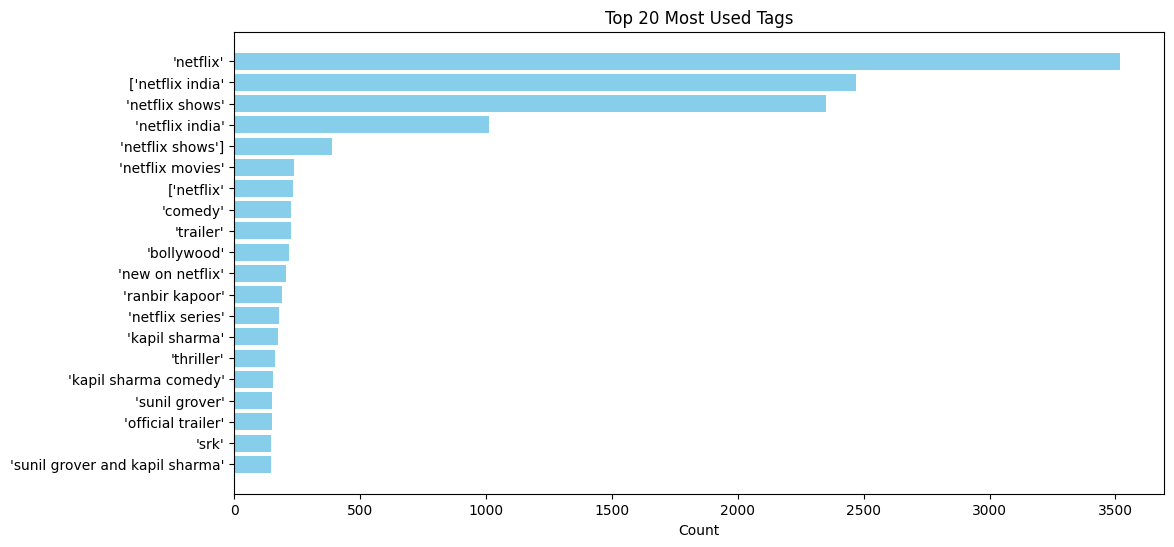

In [118]:
from collections import Counter
tags_series = df['tags'].dropna()
all_tags = [tags.strip().lower() for tags_list in tags_series for tags in tags_list.split(',')]

# Count frequency of each tag
tag_counts = Counter(all_tags)

# Convert to DataFrame for visualization
top_tags_df = pd.DataFrame(tag_counts.most_common(20), columns=['Tag', 'Count'])

# Plot the top 20 tags
plt.figure(figsize=(12, 6))
plt.barh(top_tags_df['Tag'], top_tags_df['Count'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Used Tags')
plt.gca().invert_yaxis()
plt.show()

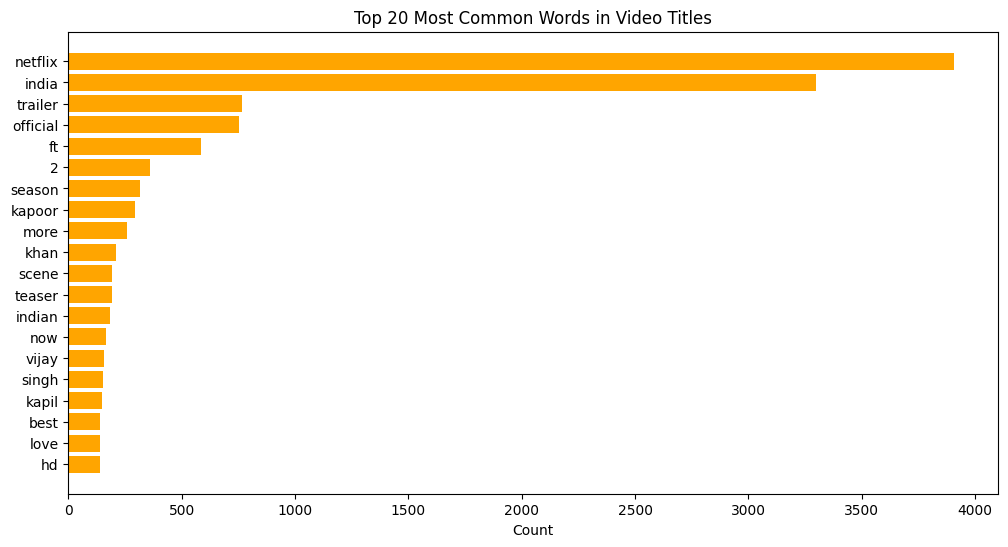

In [120]:
import re

titles_cleaned = df['title'].dropna().str.lower().apply(lambda x: re.sub(r'[^a-z0-9\s]', '', x))

# Split each title into words
all_words = [word for title in titles_cleaned for word in title.split()]

# Optionally, remove very common words (stopwords)
stopwords = {'the', 'a', 'an', 'is', 'of', 'in', 'to', 'for', 'and', 'on', 'with', 'how', 'what', 'why'}
filtered_words = [word for word in all_words if word not in stopwords]

# Count word frequency
word_counts = Counter(filtered_words)

# Convert to DataFrame
top_words_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])

# Plot
plt.figure(figsize=(12,6))
plt.barh(top_words_df['Word'], top_words_df['Count'], color='orange')
plt.xlabel('Count')
plt.title('Top 20 Most Common Words in Video Titles')
plt.gca().invert_yaxis()
plt.show()

In [128]:
print("🔎 Sample of 'viewCount' values:")
print(df['viewCount'].head(10))


🔎 Sample of 'viewCount' values:
0     52864
1     44300
2    201087
3     19642
4    117292
5    196599
6      8612
7    407963
8    120608
9    125361
Name: viewCount, dtype: int64


In [129]:
# Check type of viewCount column
print("\n🔍 Data type of 'viewCount':", df['viewCount'].dtype)


🔍 Data type of 'viewCount': int64


In [130]:
# Check for commas (string format)
print("\n🔍 Are there any commas in 'viewCount'?")
print(df['viewCount'].astype(str).str.contains(',').any())


🔍 Are there any commas in 'viewCount'?
False


In [131]:
# Check how many unique video IDs you have in total
print("\n📊 Total unique video IDs in dataset:")
print(df['video_id'].nunique())


📊 Total unique video IDs in dataset:
5134


In [136]:
df_millions = df[df['viewCount']>1_000_000]
df_millions.shape

(1248, 22)

In [137]:
df['viewCount'].isnull().sum()

np.int64(0)